In [24]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from drfp import DrfpEncoder

In [25]:
def molecule_fps_ecfp4(rxn):
    """
    Creates Morgan fingerprints for molecules
    """
    reactants, products = rxn.split('>>')
    
    arr_reactants = np.zeros((1,))
    fps_reactants = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(reactants), 2, 2048)
    ConvertToNumpyArray(fps_reactants, arr_reactants)

    arr_products = np.zeros((1,))
    fps_products = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(products), 2, 2048)
    ConvertToNumpyArray(fps_products, arr_products)
    
    reaction_fingerprint = np.concatenate((arr_reactants, arr_products))
    return reaction_fingerprint

def molecule_fps_ecfp4_6(rxn):
    """
    Creates Morgan fingerprints for molecules
    """
    reactants, products = rxn.split('>>')
    
    arr_reactants_2 = np.zeros((1,))
    fps_reactants_2 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(reactants), 2, 2048)
    ConvertToNumpyArray(fps_reactants_2, arr_reactants_2)
    
    arr_reactants_3 = np.zeros((1,))
    fps_reactants_3 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(reactants), 3, 2048)
    ConvertToNumpyArray(fps_reactants_3, arr_reactants_3)
    arr_reactants = np.concatenate((arr_reactants_2, arr_reactants_3))

    arr_products_2 = np.zeros((1,))
    fps_products_2 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(products), 2, 2048)
    ConvertToNumpyArray(fps_products_2, arr_products_2)
    
    arr_products_3 = np.zeros((1,))
    fps_products_3 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(products), 3, 2048)
    ConvertToNumpyArray(fps_products_3, arr_products_3)   
    arr_products = np.concatenate((arr_products_2, arr_products_3))
    
    reaction_fingerprint = np.concatenate((arr_reactants, arr_products))
    return reaction_fingerprint


In [26]:
delimiter = '.'
scaler = StandardScaler()
df_hte = pd.read_csv('../../df_hte_bh_rxnfp_mhfp6_no_dupl.csv')

df_hte['rxn'] = df_hte.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)
df_hte.dropna(subset = ['rxn'], inplace=True)
X3 = np.array([json.loads(x) for x in df_hte["RXNFP_FP"]])
scaler.fit(X3)
X3 = scaler.transform(X3)
X3_1 = np.array(df_hte['rxn'].apply(molecule_fps_ecfp4).tolist())

X3_2 = joblib.load("../bh_hte_drfp.pickle")
scaler.fit(X3_2)
X3_2 = scaler.transform(X3_2)
y3 = np.array(df_hte.YIELD)


#X3_1 = np.array(df_hte['rxn'].apply(molecule_fps_ecfp4_6).tolist())


y3 = np.array(df_hte.YIELD)

In [27]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
X3_1train, X3_1test, y3_1train, y3_1test = train_test_split(X3_1, y3, test_size=0.2, random_state=42)
X3_2train, X3_2test, y3_2train, y3_2test = train_test_split(X3_2, y3, test_size=0.2, random_state=42)

In [22]:
best_rfr = joblib.load("RFR_hte_hte_rxnfp_model.pkl")
best_rfr1 = joblib.load("../ECFP_experiment/RFR_hte_hte_ecfp4_6_model.pkl")
best_rfr2 = joblib.load("RFR_hte_hte_drfp_model.pkl")
best_svr = joblib.load("SVR_hte_hte_rxnfp_model.pkl")
best_svr1 = joblib.load("../ECFP_experiment/SVR_hte_hte_ecfp4_6_model.pkl")
best_svr2 = joblib.load("SVR_hte_hte_drfp_model.pkl")
best_gbr = joblib.load("GBR_hte_hte_rxnfp_model.pkl")
best_gbr1 = joblib.load("../ECFP_experiment/GBR_hte_hte_ecfp4_6_model.pkl")
best_gbr2 = joblib.load("GBR_hte_hte_drfp_model.pkl")

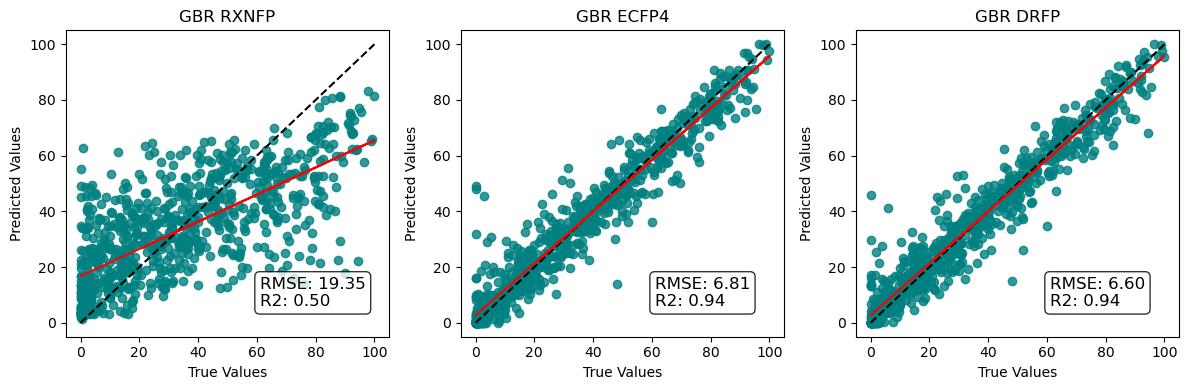

In [33]:
def plot_model(ax, y_true, y_predicted, title):
    rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
    r2 = r2_score(y_true, y_predicted)

    # Plot the data
    ax.scatter(y_true, y_predicted, color='teal', label='BH HTE', alpha=0.8)

    # Plot the diagonal line
    ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='black', linestyle='--')

    # Plot the fitting line
    fitting_line = np.polyfit(y_true, y_predicted, 1)
    ax.plot(y_true, np.polyval(fitting_line, y_true), color='r')

    # Set labels and title
#    ax.set_xlabel('True Values', fontsize=12)
#    ax.set_ylabel('Predicted Values', fontsize=12)
#    ax.set_title(title)

    # Display RMSE and R2 coefficients in the plot
    text = f'RMSE: {rmse:.2f}\nR2: {r2:.2f}'
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
    ax.text(0.6, 0.1, text, transform=ax.transAxes, fontsize=12, bbox=props)


# Iterate over different models
#names = ['RFR RXNFP', 'RFR ECFP4_6', 'RFR DRFP', 'GBR RXNFP', 'GBR ECFP4_6', 'GBR DRFP', 'SVR RXNFP', 'SVR ECFP4_6', 'SVR DRFP']
#models = [best_rfr, best_rfr1, best_rfr2, best_gbr, best_gbr1, best_gbr2, best_svr, best_svr1, best_svr2]
#X = [X3_test, X3_1test, X3_2test, X3_test, X3_1test, X3_2test, X3_test, X3_1test, X3_2test]
#Y = [y3_test, y3_1test, y3_2test, y3_test, y3_1test, y3_2test, y3_test, y3_1test, y3_2test]
names = ['GBR RXNFP', 'GBR ECFP4', 'GBR DRFP',]
models = [best_gbr, best_gbr1, best_gbr2]
X = [ X3_test, X3_1test, X3_2test,]
Y = [ y3_test, y3_1test, y3_2test,]
# Create a figure and axis
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, (model, name, x, y) in enumerate(zip(models, names, X, Y)):
    # Example y_predicted values for each model
    y_predicted = model.predict(x)
    y_predicted = np.clip(y_predicted, 0, 100) #IMPORTANT ADDITON!!!!!!
    y_true = y

    # Calculate the row and column indices for the current subplot
    col = i % 3

    # Call the plotting function for each model with the respective subplot
    plot_model(axs[col], y_true, y_predicted, "")

    # Set labels and title for each subplot
    axs[col].set_xlabel('True Values')
    axs[col].set_ylabel('Predicted Values')
    axs[ col].set_title(f'{name}')




# Adjust spacing between subplots
plt.tight_layout()

# Save or show the plot
plt.savefig('publication_plot_hte_hte.png', dpi=300)  # Save the plot as an image file
plt.show()